In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AutoReg
import warnings

# Подавление всех предупреждений
warnings.filterwarnings("ignore")


In [ ]:
Чтение и визуализация данных

No null values are in the file
             Close
Date              
2006-01-03  217.83
2006-01-04  222.84
2006-01-05  225.85
2006-01-06  233.06
2006-01-09  233.68
              Close
Date               
2017-12-22  1068.86
2017-12-26  1065.85
2017-12-27  1060.20
2017-12-28  1055.95
2017-12-29  1053.40


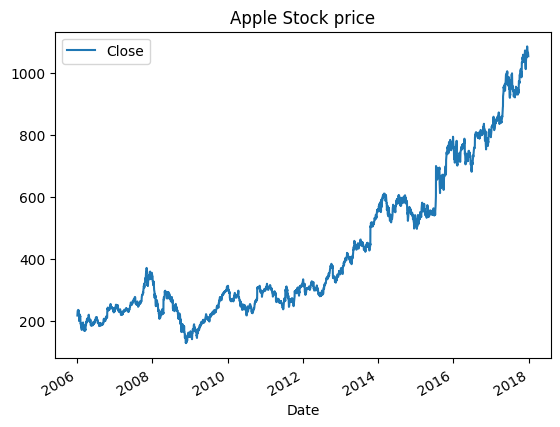

In [3]:
data = pd.read_csv('GOOGL_2006-01-01_to_2018-01-01.csv', usecols=['Date', 'Close'])

# Null values check
if data.isnull().values.any():
    print("Null values are in the file")
    # Null values interpolation
    data = data.interpolate()
else:
    print("No null values are in the file")

# deleting duplicating values
data = data.drop_duplicates()
# convert Date column to datetime object
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print(data.head())
print(data.tail())
# plot the raw data
data.plot()
plt.title("Apple Stock price")
plt.show()

In [ ]:
Проверка стационарности временного ряда

ADF Statistic: 1.3224241360302142
p-value: 0.9967315857800989
Critical Values:
   1%: -3.4325396703967974
   5%: -2.862507454335551
   10%: -2.5672850015989264
The series is not stationary.


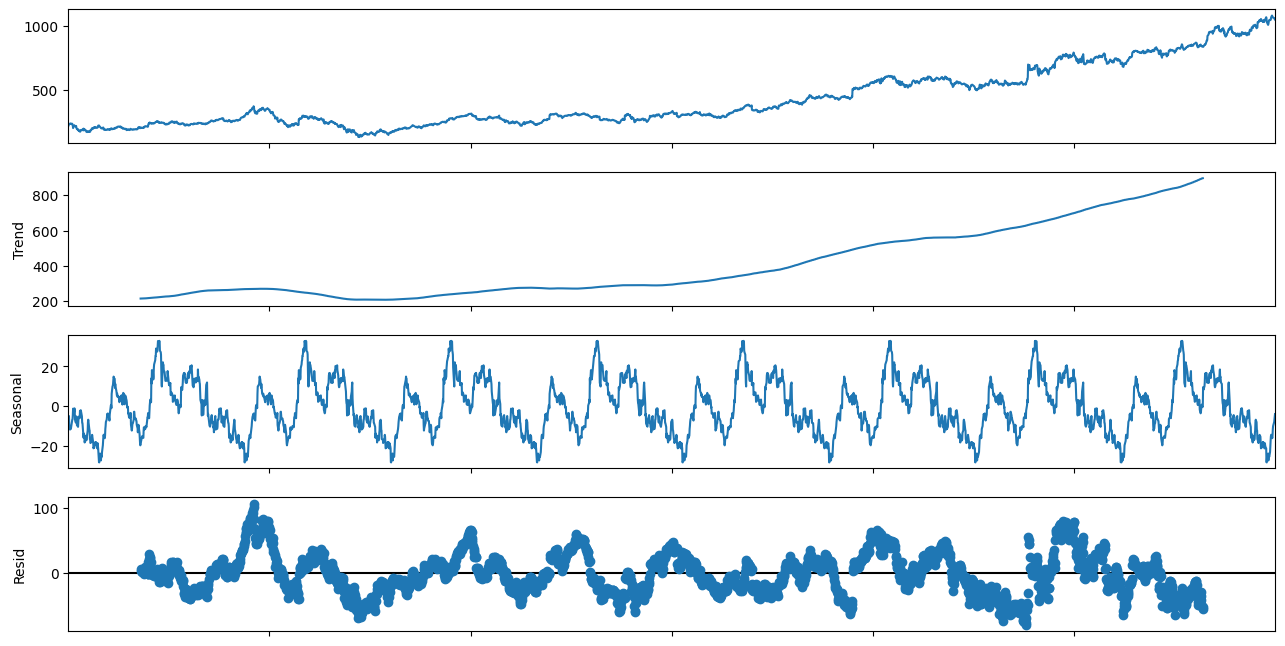

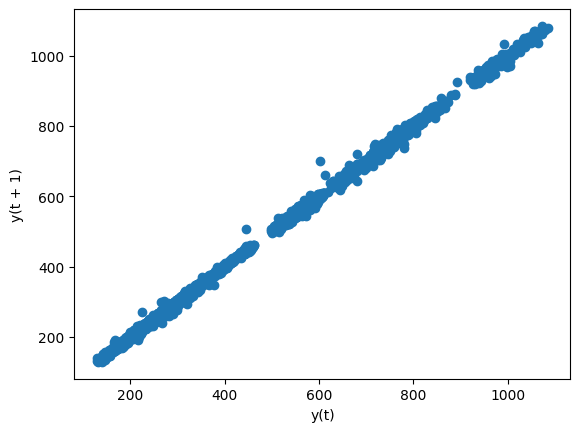

In [4]:
# Perform Augmented Dickey-Fuller test
result = adfuller(data["Close"].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Check if the series is stationary
significance_level = 0.05
if result[1] < significance_level:
    print("The series is stationary.")
else:
    print("The series is not stationary.")

# seaonal decompose
decomposition = sm.tsa.seasonal_decompose(data, model='additive', period=365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
fig.set_size_inches(14, 7)
for ax in fig.axes:
    ax.set_xticklabels([])
plt.show()

# plot lag plot
from pandas.plotting import lag_plot

series = pd.Series(data["Close"])
lag_plot(series)
plt.show()



In [ ]:
ACF и PACF

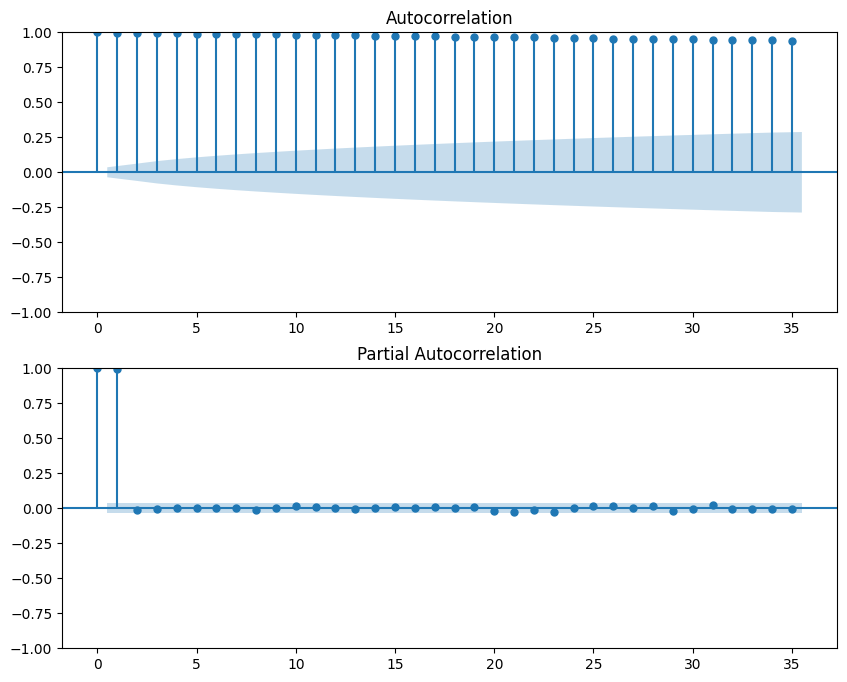

In [46]:
# plot autocorrelation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(data.Close.dropna(), ax=ax1)
plot_pacf(data.Close.dropna(), ax=ax2)

plt.show()

In [ ]:
Holt model

In [143]:
from statsmodels.tsa.holtwinters import Holt

# split dataset
horizon = 10  # горизонт прогнозирования

X = series.values
train, test = X[1:len(X) - 10], X[len(X) - 10:]
print("train")
print(train)
print("test")
print(test)
# train Holt model
holt_params = {'trend': 'add'}
holt_model = ExponentialSmoothing(train_data, **holt_params)
model_fit = holt_model.fit()
# Predict
predictions = model_fit.predict(start=len(train), end=len(train) + horizon - 1)

train
[ 222.84  225.85  233.06 ... 1048.77 1051.39 1057.47]
test
[1072.   1085.09 1079.78 1073.56 1070.85 1068.86 1065.85 1060.2  1055.95
 1053.4 ]


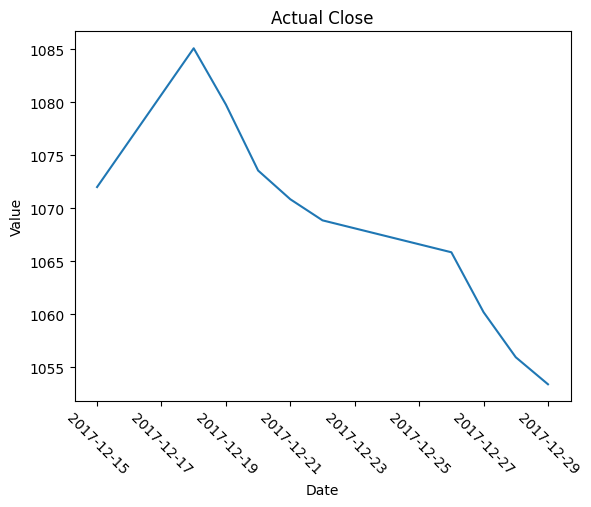

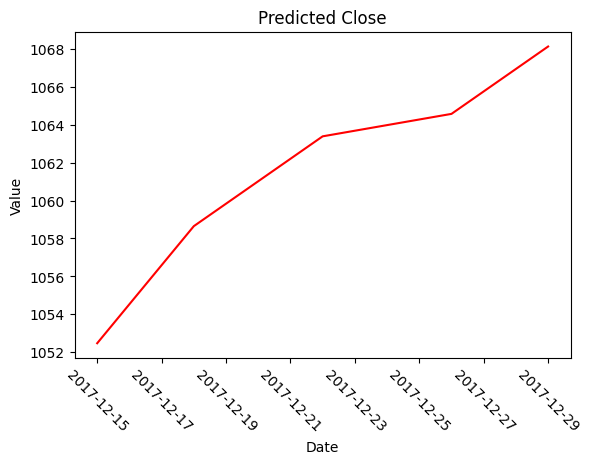

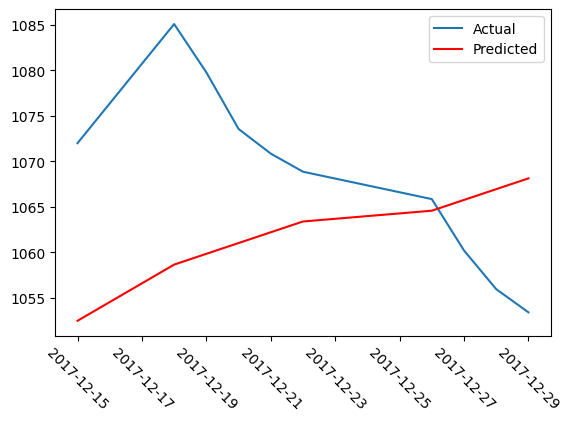

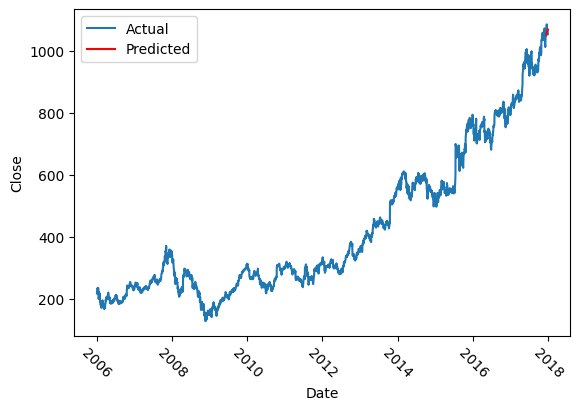

RMSE = 14.53, Efficiency = 98.64%


<Figure size 640x480 with 0 Axes>

In [144]:
from math import sqrt
# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index, data['Close'], label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=-45)

plt.show()
plt.gcf().autofmt_xdate()

# Convert test to DataFrame
test_df = pd.DataFrame(test, index=data.index[-len(test):], columns=['Close'])

# Compute RMSE and efficiency
holt_rmse_val = sqrt(mean_squared_error(test_df['Close'], predictions))
efficiency = (1 - (holt_rmse_val / test_df['Close'].mean())) * 100
print("RMSE = {:.2f}, Efficiency = {:.2f}%".format(holt_rmse_val, efficiency))

In [123]:
Browns model

In [145]:
# train Brown's model
brown_params = {'lags': 4}

brown_model = AutoReg(train_data, **brown_params)
model_fit = brown_model.fit()
print("train")
print(train)
print("test")
print(test)
# Predict
predictions = model_fit.forecast(steps=len(test))

train
[ 222.84  225.85  233.06 ... 1048.77 1051.39 1057.47]
test
[1072.   1085.09 1079.78 1073.56 1070.85 1068.86 1065.85 1060.2  1055.95
 1053.4 ]


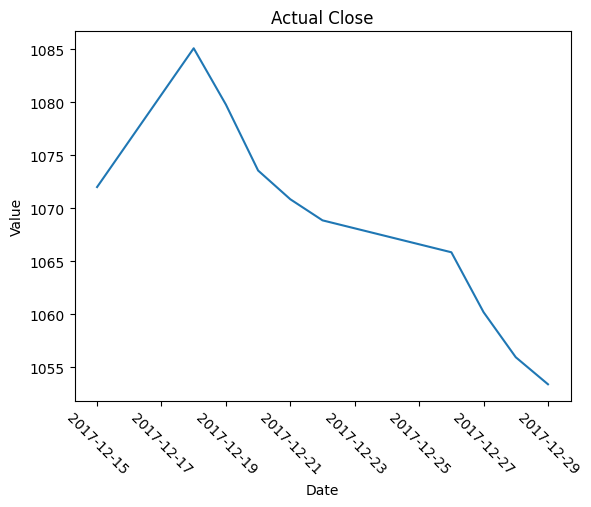

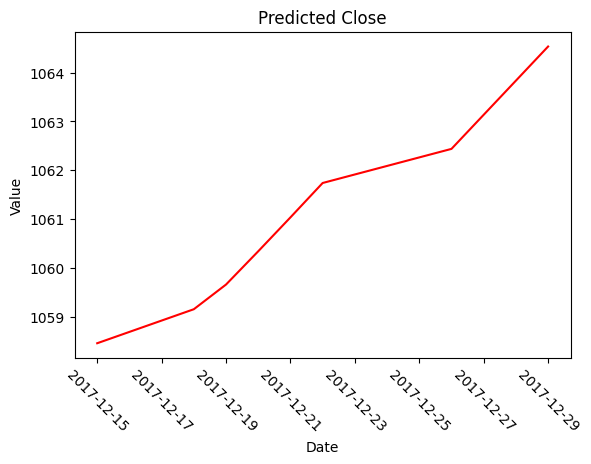

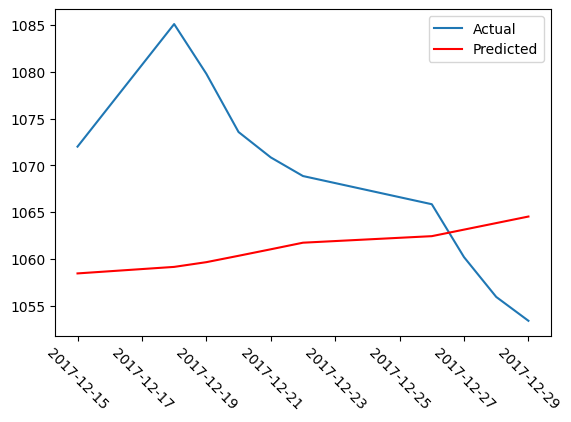

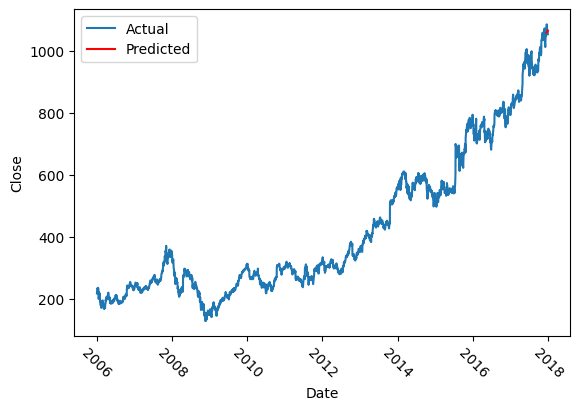

RMSE = 13.37, Efficiency = 98.75%


<Figure size 640x480 with 0 Axes>

In [146]:
from math import sqrt
# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index, data['Close'], label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=-45)

plt.show()
plt.gcf().autofmt_xdate()

# Convert test to DataFrame
test_df = pd.DataFrame(test, index=data.index[-len(test):], columns=['Close'])

# Compute RMSE and efficiency
brown_rmse_val = sqrt(mean_squared_error(test_df['Close'], predictions))
efficiency = (1 - (brown_rmse_val / test_df['Close'].mean())) * 100
print("RMSE = {:.2f}, Efficiency = {:.2f}%".format(brown_rmse_val, efficiency))

In [ ]:
Holt-Winters model

In [147]:
# train Holt-Winters model
holt_winters_params = {'trend': 'add', 'seasonal': 'add', 'seasonal_periods': 12}

model = ExponentialSmoothing(train_data, **holt_winters_params)
model_fit = model.fit()
print("train")
print(train)
print("test")
print(test)
# Predict
predictions = model_fit.forecast(steps=len(test))

train
[ 222.84  225.85  233.06 ... 1048.77 1051.39 1057.47]
test
[1072.   1085.09 1079.78 1073.56 1070.85 1068.86 1065.85 1060.2  1055.95
 1053.4 ]


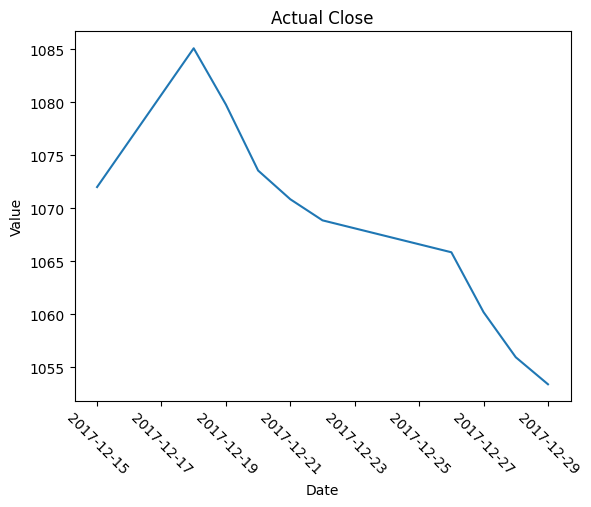

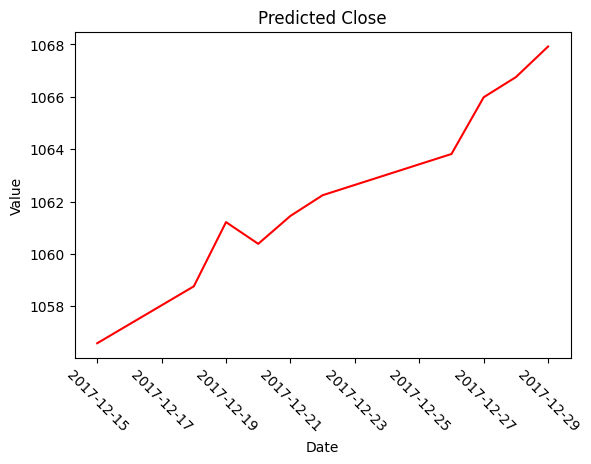

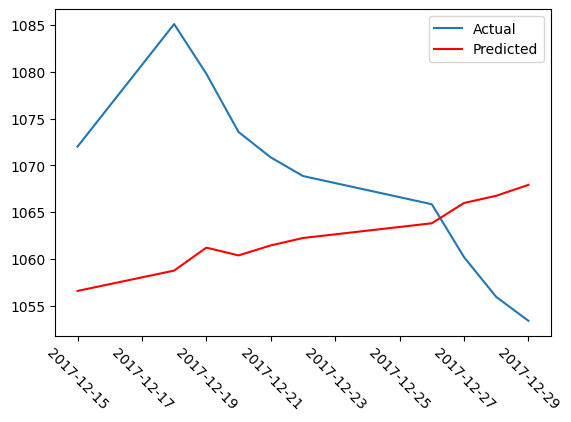

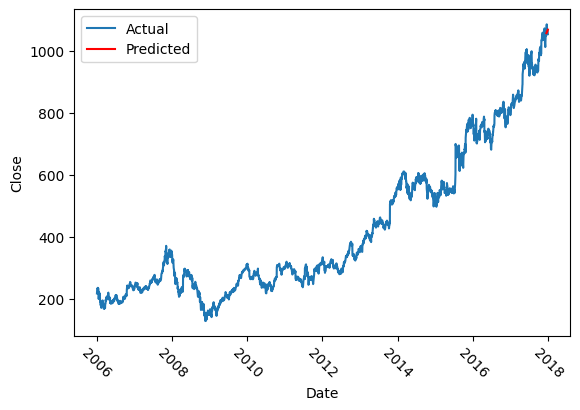

RMSE = 13.95, Efficiency = 98.69%


<Figure size 640x480 with 0 Axes>

In [148]:
from math import sqrt
# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index, data['Close'], label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=-45)

plt.show()
plt.gcf().autofmt_xdate()

# Convert test to DataFrame
test_df = pd.DataFrame(test, index=data.index[-len(test):], columns=['Close'])

# Compute RMSE and efficiency
holt_winters_rmse_val = sqrt(mean_squared_error(test_df['Close'], predictions))
efficiency = (1 - (holt_winters_rmse_val / test_df['Close'].mean())) * 100
print("RMSE = {:.2f}, Efficiency = {:.2f}%".format(holt_winters_rmse_val, efficiency))

In [ ]:
Trigg-Lite

In [149]:
# train Trigg-Lite model
trigg_lite_params = {'trend': 'add', 'seasonal': None}

model = ExponentialSmoothing(train_data, **trigg_lite_params)
model_fit = model.fit()
print("train")
print(train)
print("test")
print(test)
# Predict
predictions = model_fit.forecast(steps=len(test))

train
[ 222.84  225.85  233.06 ... 1048.77 1051.39 1057.47]
test
[1072.   1085.09 1079.78 1073.56 1070.85 1068.86 1065.85 1060.2  1055.95
 1053.4 ]


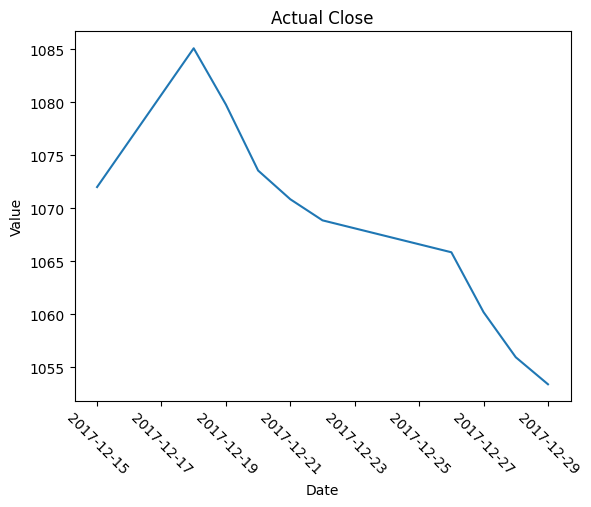

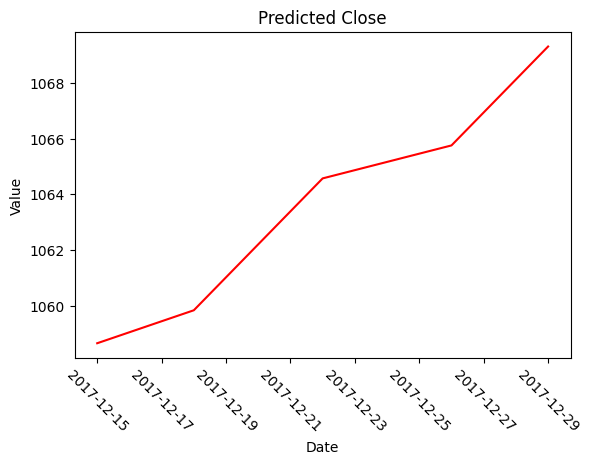

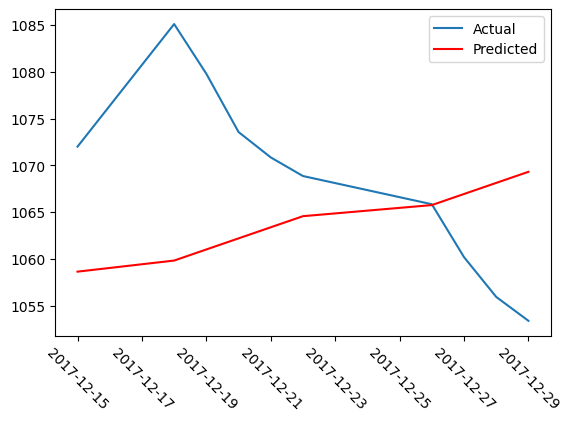

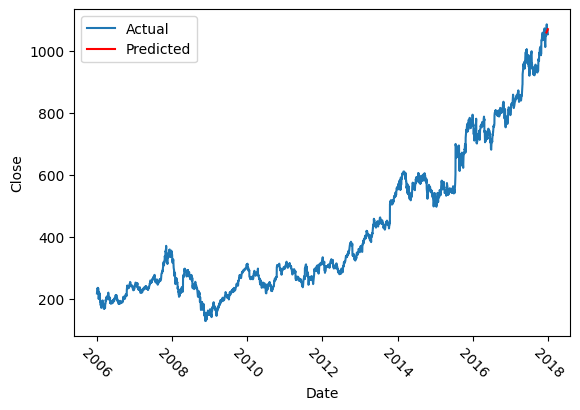

RMSE = 13.48, Efficiency = 98.74%


<Figure size 640x480 with 0 Axes>

In [150]:
from math import sqrt
# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Predicted Close')
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index[-10:], test, label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xticks(rotation=-45)
plt.show()
plt.gcf().autofmt_xdate()

# plot forecasts against actual outcomes
plt.plot(data.index, data['Close'], label='Actual')
plt.plot(data.index[-10:], predictions, color='red', label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close')
plt.xticks(rotation=-45)

plt.show()
plt.gcf().autofmt_xdate()

# Convert test to DataFrame
test_df = pd.DataFrame(test, index=data.index[-len(test):], columns=['Close'])

# Compute RMSE and efficiency
trig_lite_rmse_val = sqrt(mean_squared_error(test_df['Close'], predictions))
efficiency = (1 - (trig_lite_rmse_val / test_df['Close'].mean())) * 100
print("RMSE = {:.2f}, Efficiency = {:.2f}%".format(trig_lite_rmse_val, efficiency))

In [153]:
# Словарь для хранения RMSE для каждой модели
rmse_dict = {
    "Brown's model": brown_rmse_val,
    "Holt's model": holt_rmse_val,
    "Holt-Winters' model": holt_winters_rmse_val,
    "Trigg-Lite's model": trig_lite_rmse_val
}

print(rmse_dict)
print("\n")

# Нахождение модели с наименьшим RMSE
most_effective_model = min(rmse_dict, key=rmse_dict.get)
most_effective_rmse = rmse_dict[most_effective_model]

# Вывод наименьшего RMSE и названия соответствующей модели
print("Most effective model:", most_effective_model)
print("Most effective RMSE:", most_effective_rmse)
print("\n")
# Нахождение модели с наибольшим RMSE (наименее эффективной модели)
least_effective_model = max(rmse_dict, key=rmse_dict.get)
least_effective_rmse = rmse_dict[least_effective_model]

# Вывод наибольшего RMSE и названия соответствующей модели
print("Least effective model:", least_effective_model)
print("Least effective RMSE:", least_effective_rmse)



{"Brown's model": 13.374140205491713, "Holt's model": 14.527888721438844, "Holt-Winters' model": 13.950371802507425, "Trigg-Lite's model": 13.483712918828589}


Most effective model: Brown's model
Most effective RMSE: 13.374140205491713


Least effective model: Holt's model
Least effective RMSE: 14.527888721438844


In [ ]:
1. Модель Брауна (AutoReg):
        Основана на авторегрессии.
        Предполагает, что текущее значение временного ряда зависит от предыдущих значений с заданным лагом.
        Простая и эффективная для стационарных временных рядов.
         
2. Модель Хольта (ExponentialSmoothing):
        Основана на экспоненциальном сглаживании.
        Учитывает тренд, но не учитывает сезонность.
        Подходит для временных рядов с постепенно меняющимися трендами.
        
3. Модель Хольта-Винтерса (ExponentialSmoothing с сезонностью):
        Расширение модели Хольта, учитывающее сезонность.
        Подходит для временных рядов с ярко выраженной сезонностью.

4. Модель Тригга-Лича (ExponentialSmoothing без сезонности):
        Аналогична модели Хольта-Винтерса, но без учета сезонности.
        Подходит для временных рядов без явной сезонности.